# Analysis of matrices

Herman Kamper, 2024

In [20]:
from datetime import datetime
from numpy import linalg
from pathlib import Path
from tqdm.notebook import tqdm
import celer
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import torchaudio

sys.path.append("..")

from utils import fast_cosine_dist, pca_transform, pca_inverse_transform

In [5]:
device = "cuda"

## Utilities

In [6]:
n_fft = 256
n_overlap = 128
sr = 16000
pad_xextent = (n_fft - n_overlap)/sr/2

def specgram(x, sr):
    """
    Return the spectrogram array and extent.
    
    Based on:
    <https://stackoverflow.com/questions/53385242/matplotlib-spectrogram-animation-without-calling-pyplot-specgram-directly-every>
    """
    spec, freqs, t = plt.mlab.specgram(x, Fs=sr)
    x_min = np.min(t) - pad_xextent
    x_max = np.max(t) + pad_xextent
    extent = x_min, x_max, freqs[0], freqs[-1]
    arr = np.flipud(10*np.log10(spec))
    return arr, extent

## Models

In [7]:
wavlm = torch.hub.load("bshall/knn-vc", "wavlm_large", trust_repo=True, device=device)

Using cache found in /home/kamperh/.cache/torch/hub/bshall_knn-vc_master
/home/kamperh/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


WavLM-Large loaded with 315,453,120 parameters.


In [8]:
hifigan, _ = torch.hub.load("bshall/knn-vc", "hifigan_wavlm", trust_repo=True, device=device, prematched=True)

Removing weight norm...
[HiFiGAN] Generator loaded with 16,523,393 parameters.


Using cache found in /home/kamperh/.cache/torch/hub/bshall_knn-vc_master


## LinearVC

In [9]:
features_dir = Path("/home/kamperh/scratch/vctk/wavlm/")
wav_dir = Path("/home/kamperh/scratch/vctk/wav/")
# source = "p279"
source = "p225"
# target = "p282"
target = "p287"

In [10]:
source_feats_all = np.load((features_dir / source).with_suffix(".npy"))
target_feats_all = np.load((features_dir / target).with_suffix(".npy"))

In [46]:
k_top = 1
n_frames = 8192

source_feats = torch.from_numpy(source_feats_all[:n_frames, :]).float().to(device)
target_feats = torch.from_numpy(target_feats_all[:n_frames, :]).float().to(device)

print(datetime.now())
print("Matching")

dists = fast_cosine_dist(
    source_feats.squeeze(), target_feats, device=device
)
best = dists.topk(k=k_top, largest=False, dim=-1)
linear_target = target_feats[best.indices].mean(dim=1)

print(datetime.now())
print("Regression")
b = None

# Normal
# W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())

# Lasso
linear = celer.Lasso(alpha=0.3, fit_intercept=False).fit(
    source_feats.squeeze().cpu(), linear_target.cpu()
)
W = linear.coef_.T

# # Lasso with bias
# linear = celer.Lasso(alpha=0.3, fit_intercept=True).fit(
#     source_feats.squeeze().cpu(), linear_target.cpu()
# )
# W = linear.coef_.T
# b = linear.intercept_

# # Regularised ridge regression
# from reduced_rank_ridge import ReducedRankRidge
# rank = 25
# linear = ReducedRankRidge(alpha=1.0, fit_intercept=False, rank=rank).fit(
#     source_feats.squeeze().cpu(), linear_target.cpu()
# )
# W = linear.Vr @ linear.Vrt_times_beta
# W = W.T

print(datetime.now())

W = torch.from_numpy(W).float().to(device)
if not b is None:
    b = torch.from_numpy(b).float().to(device)

2024-11-13 08:08:04.551842
Matching
2024-11-13 08:08:04.552915
Regression
2024-11-13 08:09:10.951214


In [47]:
wav_fn = wav_dir / source / f"{source}_057.wav"
# wav_fn = wav_dir / source / f"{source}_051.wav"
wav, _ = torchaudio.load(wav_fn)
wav = wav.to(device)
display.Audio(wav.squeeze().cpu(), rate=16000)

In [48]:
with torch.inference_mode():
    feats, _ = wavlm.extract_features(
        wav, output_layer=6
    )

if b is None:
    source_to_target_feats = feats @ W
else:
    source_to_target_feats = feats @ W + b

with torch.inference_mode():
    wav_hat = hifigan(source_to_target_feats).squeeze(0)

In [49]:
source_to_target_feats[0, 0, :]

tensor([-2.5332, -2.2839, -1.6011,  ..., -2.5058,  3.5658,  0.6015],
       device='cuda:0')

In [50]:
torch.dot(feats[0, 0, :], W[:, 0])

tensor(-2.5332, device='cuda:0')

In [51]:
torch.dot(feats[0, 0, :], W[:, 1])

tensor(-2.2839, device='cuda:0')

In [52]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)

In [53]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)

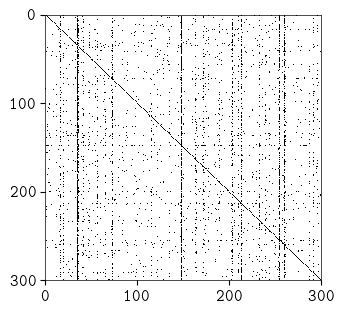

In [54]:
# Figure for paper
columnwidth_in = 3.1614172222244096844*0.7
columnwidth_in = columnwidth_in * 12 / 8  # 12pt font here should appear as 8pt

plt.rcParams.update(
    {
        "figure.subplot.bottom": 0.08,
        "figure.subplot.left": 0.12,
        "figure.subplot.right": 0.95,
        "figure.subplot.top": 0.97,
        "font.family": "monospace",
        "font.serif": "Computer Modern Roman",
        "font.sans-serif": "Computer Modern Sans serif",
        "font.size": 12,
        "legend.fontsize": "medium",
        "text.usetex": True,
        "axes.linewidth": 0.5,
        "lines.linewidth": 1,
        "lines.markersize": 5,
        "lines.markeredgewidth": 0,
        "savefig.transparent": True,
    }
)

W_numpy = W.cpu().numpy()
matrix = W_numpy.copy()
matrix[np.abs(matrix) < 1e-4] = 0.0
matrix[np.abs(matrix) > 1e-4] = 1.0
fig, ax = plt.subplots(1, 1, figsize=(columnwidth_in, columnwidth_in*0.9))
ax.imshow(matrix.T, cmap="binary", aspect="auto", interpolation="none")

# ax.set_title(r"$\mathbf{W}^\top$")
ax.set_xticks([0, 100, 200, 300, 400, 500])
ax.set_yticks([0, 100, 200, 300, 400, 500])
ax.set_xlim([0, 300])
ax.set_ylim([300, 0])

from matplotlib.ticker import FormatStrFormatter
ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
ax.yaxis.set_major_formatter(FormatStrFormatter("%d"))

plt.savefig(f"W_transpose_{source}-{target}.pdf")

In [19]:
threshold = 1e-4
print(
    "Proportion zero: {:.2f}%".format(
        len(np.where(np.abs(W_numpy) < threshold)[0])
        / W_numpy.shape[0] ** 2
        * 100
    )
)
print(
    "No. zero rows in W^T:",
    len(np.where((np.abs(W_numpy.T) < threshold).all(axis=1))[0]),
)
print(
    "No. zero columns in W^T:",
    len(np.where((np.abs(W_numpy.T) < threshold).all(axis=0))[0]),
)
print(
    "No. of zero elements on diagonal:",
    len(np.where(np.abs(np.diag(W_numpy)) < threshold)[0]),
)
print("Matrix rank:", linalg.matrix_rank(W_numpy, tol=threshold))
print("Determinant:", linalg.det(W_numpy))


Proportion zero: 96.09%
No. zero rows in W^T: 0
No. zero columns in W^T: 0
No. of zero elements on diagonal: 0
Matrix rank: 1024
Determinant: 0.0


### Let's set some rows to zero

In [46]:
zero_rows = np.where((np.abs(W_numpy.T) < threshold).all(axis=1))[0]
print(zero_rows)

[  6  40 130 239 245 277 352 374 404 411 463 469 546 573 624 637 652 679
 702 861 879 880 935 985]


In [47]:
wav_fn = wav_dir / source / f"{source}_057.wav"
# wav_fn = wav_dir / source / f"{source}_051.wav"
wav, _ = torchaudio.load(wav_fn)
wav = wav.to(device)
display.Audio(wav.squeeze().cpu(), rate=16000)

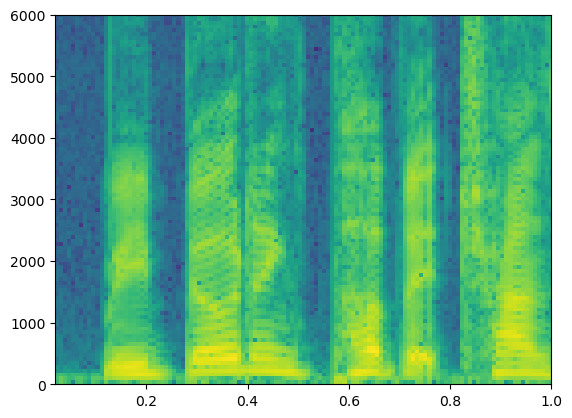

In [55]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
arr, extent = specgram(wav.squeeze().cpu(), sr=sr)
image = ax.imshow(
    arr,
    extent=extent,
    aspect="auto"
)
ax.set_xlim([0.02, 1])
ax.set_ylim([0, 6000]);

In [49]:
with torch.inference_mode():
    feats, _ = wavlm.extract_features(
        wav, output_layer=6
    )

    feats[0, :, zero_rows] = 0

with torch.inference_mode():
    wav_hat = hifigan(feats).squeeze(0)

In [50]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)

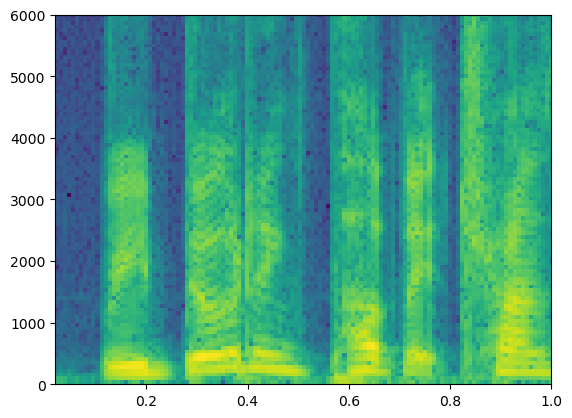

In [54]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
arr, extent = specgram(wav_hat.squeeze().cpu(), sr=sr)
image = ax.imshow(
    arr,
    extent=extent,
    aspect="auto"
)
ax.set_xlim([0.02, 1])
ax.set_ylim([0, 6000]);

## LinearVC on 256-dimensional WavLM

In [6]:
features_dir = Path("/home/kamperh/scratch/vctk/wavlm_256/")
wav_dir = Path("/home/kamperh/scratch/vctk/wav/")
source = "p279"
# source = "p225"
target = "p282"
# target = "p287"

In [7]:
pca_fn = Path("../data/wavlm_pca_256.npz")
pca = np.load(pca_fn)
pca_feats = {}
for key in ["mean", "components", "explained_variance"]:
    pca_feats[key] = torch.from_numpy(pca[key]).float().to(device)

In [8]:
source_feats_all = np.load((features_dir / source).with_suffix(".npy"))
target_feats_all = np.load((features_dir / target).with_suffix(".npy"))

In [25]:
k_top = 1
n_frames = 8192

source_feats = (
    torch.from_numpy(source_feats_all[:n_frames, :]).float().to(device)
)
target_feats = (
    torch.from_numpy(target_feats_all[:n_frames, :]).float().to(device)
)

dists = fast_cosine_dist(source_feats.squeeze(), target_feats, device=device)
best = dists.topk(k=k_top, largest=False, dim=-1)
linear_target = target_feats[best.indices].mean(dim=1)

# W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())
linear = celer.Lasso(alpha=0.05, fit_intercept=False).fit(
# linear = celer.Lasso(alpha=5.0, fit_intercept=False).fit(
    source_feats.squeeze().cpu(), linear_target.cpu()
)
W = linear.coef_.T

W = torch.from_numpy(W).float().to(device)

In [26]:
wav_fn = wav_dir / source / f"{source}_057.wav"
# wav_fn = wav_dir / source / f"{source}_051.wav"
wav, _ = torchaudio.load(wav_fn)
wav = wav.to(device)
display.Audio(wav.squeeze().cpu(), rate=16000)

In [27]:
with torch.inference_mode():
    feats, _ = wavlm.extract_features(
        wav, output_layer=6
    )
feats_z = pca_transform(
    feats, pca_feats["mean"], pca_feats["components"],
    pca_feats["explained_variance"]
)    
source_to_target_feats_z = feats_z @ W
source_to_target_feats = pca_inverse_transform(
    source_to_target_feats_z, pca_feats["mean"], pca_feats["components"],
    pca_feats["explained_variance"]
)

with torch.inference_mode():
    wav_hat = hifigan(source_to_target_feats).squeeze(0)

In [28]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)

Text(0.5, 1.0, '$W^{T}$')

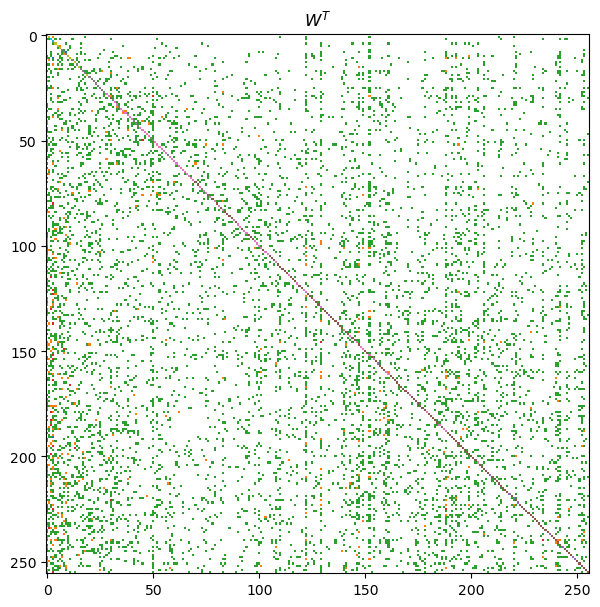

In [29]:
W_numpy = W.cpu().numpy()
matrix = W_numpy.copy()
matrix[matrix == 0.0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(matrix.T, interpolation="none", aspect="auto", cmap="tab10")
ax.set_title("$W^{T}$")

In [14]:
print(
    "Proportion zero: {:.2f}%".format(
        np.count_nonzero(W_numpy == 0) / W_numpy.shape[0] ** 2 * 100
    )
)
print("Determinant:", linalg.det(W_numpy))


Proportion zero: 98.08%
Determinant: 0.0
